In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread_collection
import shutil
import random

In [ ]:
!git clone https://github.com/AruSahu/imgTransferDMFinal.git

Cloning into 'imgTransferDMFinal'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 474.17 MiB | 14.74 MiB/s, done.
Updating files: 100% (970/970), done.


In [ ]:
ai_art_paths = []
real_art_paths = []

In [ ]:
path_ai = '/content/imgTransferDMFinal/AiArtData/AiArtData'  # Adjust the path pattern according to your directory structure
for filename in os.listdir(path_ai):
    ai_art_paths.append(os.path.join(filename))

In [ ]:
path_real = '/content/imgTransferDMFinal/RealArt/RealArt'  # Adjust the path pattern according to your directory structure
for filename in os.listdir(path_real):
    real_art_paths.append(os.path.join(filename))

In [ ]:
train_paths_ai, test_paths_ai = train_test_split(ai_art_paths, test_size=0.2)
val_paths_ai, test_paths_ai = train_test_split(test_paths_ai, test_size=0.5)

In [ ]:
train_paths_real, test_paths_real = train_test_split(real_art_paths, test_size=0.2)
val_paths_real, test_paths_real = train_test_split(test_paths_real, test_size=0.5)

In [ ]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

In [ ]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
os.makedirs(train_dir+'/real', exist_ok=True)
os.makedirs(val_dir+'/real', exist_ok=True)
os.makedirs(test_dir+'/real', exist_ok=True)
os.makedirs(train_dir+'/ai', exist_ok=True)
os.makedirs(val_dir+'/ai', exist_ok=True)
os.makedirs(test_dir+'/ai', exist_ok=True)

In [ ]:
for path in train_paths_ai:
    shutil.copy(path_ai+'/'+path, os.path.join(train_dir+'/ai', os.path.basename(path)))
for path in test_paths_ai:
    shutil.copy(path_ai+'/'+path, os.path.join(test_dir+'/ai', os.path.basename(path)))
for path in val_paths_ai:
    shutil.copy(path_ai+'/'+path, os.path.join(val_dir+'/ai', os.path.basename(path)))
for path in train_paths_real:
    shutil.copy(path_real+'/'+path, os.path.join(train_dir+'/real', os.path.basename(path)))
for path in test_paths_real:
    shutil.copy(path_real+'/'+path, os.path.join(test_dir+'/real', os.path.basename(path)))
for path in val_paths_real:
    shutil.copy(path_real+'/'+path, os.path.join(val_dir+'/real', os.path.basename(path)))

In [ ]:
# prompt:  # Load pre-trained VGG19 model without top layers

from tensorflow.keras.applications import VGG19
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
with tf.device('/gpu:0'):

    # Define parameters
    img_width, img_height = 224, 224
    batch_size = 96
    epochs = 25

    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Rescaling for validation and test data
    validation_test_datagen = ImageDataGenerator(rescale=1./255)

    # Data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Freeze convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(2, activation='softmax')  # Adjust the number of units according to your classification task
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )

    # Evaluate the model on test set
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
    print("Test Accuracy:", test_acc)

Found 773 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 [==============================] - 47s 4s/step - loss: 5.2224 - accuracy: 0.4505 - val_loss: 0.7743 - val_accuracy: 0.5521
Epoch 2/25
8/8 [==============================] - 32s 4s/step - loss: 1.0682 - accuracy: 0.5482 - val_loss: 0.8933 - val_accuracy: 0.4375
Epoch 3/25
8/8 [==============================] - 35s 4s/step - loss: 0.7313 - accuracy: 0.5746 - val_loss: 0.7315 - val_accuracy: 0.5417
Epoch 4/25
8/8 [==============================] - 30s 4s/step - loss: 0.6644 - accuracy: 0.6263 - val_loss: 0.6294 - val_accuracy: 0.6458
Epoch 5/25
8/8 [==============================] - 28s 3s/step - loss: 0.6116 - accuracy: 0.6588 - val_loss: 0.5665 - val_accuracy: 0.6771
Epoch 6/25
8/8 [==============================] - 29s 3s/step - loss: 0.5476 - accuracy: 0.7194 - val_loss: 0.5489 - val_accuracy: 0.7188
Epoch 7/25
8/8 [==============================] - 30s 4s/step - loss: 0.5340 - accuracy: 0.7341 - val_loss: 0.5674 - val_accuracy: 0.6979
Epoch 8/25
8/8 [=============================

In [ ]:
model.save("DM_VFF19.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Define the desired image size
IMAGE_SIZE = (224, 224)
def load_and_preprocess_image(image_path):
  # Load the image using OpenCV
  image = cv2.imread(image_path)

  # Resize the image to the desired size
  image = cv2.resize(image, IMAGE_SIZE)

  # Normalize the pixel values to the range [0, 1]
  image = image.astype("float32") / 255.0

  # Return the preprocessed image
  return image

1/1 [==============================] - 0s 67ms/step
Probability of being AI-generated: 0.09946045
Probability of being real: 0.9005396




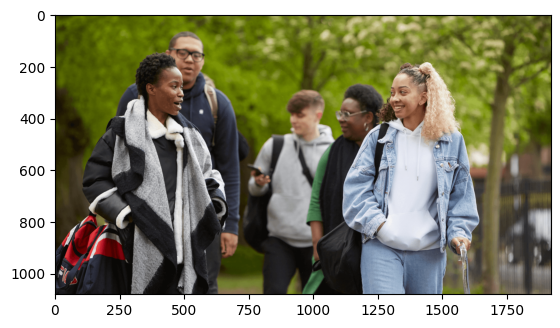


The image is Real


In [ ]:
# prompt: make predictions on new images. It should output a probability score for each class, indicating the likelihood of the image being AI-generated or real.

# Load the new image
new_image_path = '/content/imgTransferDMFinal/RealArt/RealArt/0182.png'
new_image = load_and_preprocess_image(new_image_path)
image = mpimg.imread(new_image_path)

# Make a prediction on the new image
prediction = model.predict(np.expand_dims(new_image, axis=0))
# print(prediction)
# Print the prediction probabilities
print('Probability of being AI-generated:', prediction[0][0])
print('Probability of being real:', prediction[0][1])
print("\n")

plt.imshow(image)
plt.show()

print("\nThe image is", "AI generated" if prediction[0][0]> 0.5 else "Real")


1/1 [==============================] - 0s 39ms/step
Probability of being AI-generated: 0.9776242
Probability of being real: 0.022375863




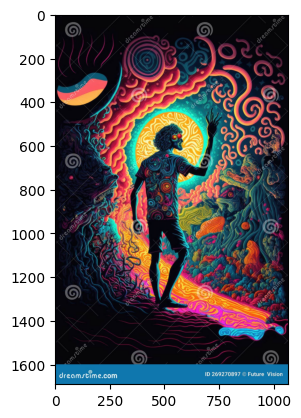


The image is AI generated


In [ ]:
# prompt: make predictions on new images. It should output a probability score for each class, indicating the likelihood of the image being AI-generated or real.

# Load the new image
new_image_path = '/content/imgTransferDMFinal/AiArtData/AiArtData/-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg'
new_image = load_and_preprocess_image(new_image_path)
image = mpimg.imread(new_image_path)

# Make a prediction on the new image
prediction = model.predict(np.expand_dims(new_image, axis=0))
# print(prediction)
# Print the prediction probabilities
print('Probability of being AI-generated:', prediction[0][0])
print('Probability of being real:', prediction[0][1])
print("\n")

plt.imshow(image)
plt.show()

print("\nThe image is", "AI generated" if prediction[0][0]> 0.5 else "Real")


In [ ]:
# Evaluated the model on the test set
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))

# Calculated the precision, recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred = model.predict(np.array(test_images))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(np.array(test_labels), axis=1)
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

# Print the results
print('Testing Loss:', test_loss)
print('Testing Accuracy:', test_accuracy)
print('Testing Precision:', precision)
print('Testing Recall:', recall)
print('Testing F1-Score:', f1)


In [ ]:
import numpy as np
# Calculate the training metrics
train_loss, train_accuracy = model.evaluate(np.array(train_images), np.array(train_labels))
y_pred_train = model.predict(np.array(train_images))
y_pred_classes_train = np.argmax(y_pred_train, axis=1)
y_true_classes_train = np.argmax(np.array(train_labels), axis=1)
train_precision = precision_score(y_true_classes_train, y_pred_classes_train)
train_recall = recall_score(y_true_classes_train, y_pred_classes_train)
train_f1 = f1_score(y_true_classes_train, y_pred_classes_train)
train_auc = tf.keras.metrics.AUC(num_thresholds=500)(np.array(train_labels), y_pred_train)

# Print the training metrics
print('Training Loss:', train_loss)
print('Training Accuracy:', train_accuracy)
print('Training Precision:', train_precision)
print('Training Recall:', train_recall)
print('Training F1-Score:', train_f1)
print('Training AUC:', train_auc)


In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()